<a href="https://colab.research.google.com/github/AnIsAsPe/Estimacion-probabilidad-conflicto-en-trayectorias-de-vuelos-paralelos/blob/main/Notebooks/Estimaci%C3%B3n_probabilidad_de_conflicto_en_trayectorias_de_vuelo_Montecarlo_CadenaMarkov_ipynbipynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

# Funciones

$\mathbb{Cov}(error_{a,t},~error_{a,s}) = r_a^2t^2$    

$\mathbb{Cov}(error_{c,t},~error_{c,s}) = \sigma_c^2(1-e^{-2\frac{r_c}{\sigma_c}vt})e^{-\frac{r_c}{\sigma_c}v(s-t)}$  


---
R. A. Paielli y H. Erzberger, «Conflict Probability Estimation for Free Flight», Journal of Guidance, Control, and Dynamics, may 2012, doi: 10.2514/2.4081.


In [2]:
def covarianzas(r_a, sigma_c, r_c, v ): 
  covA=np.zeros((20,20))
  covC=np.zeros((20,20))
  for s in range(20):
    covC[s,s]=(sigma_c**2)*(1-np.exp(-2*r_c*v*(s+1)/sigma_c))
    covA[s,s]=(r_a**2)*((s+1)**2)
    for t in range(s):
        covC[t,s]=covC[s,t]=(sigma_c**2)*(1-np.exp(-2*r_c*v*(t+1)/sigma_c))*np.exp(-r_c*v*(s-t)/sigma_c)
        covA[t,s]=covA[s,t]=(r_a**2)*((t+1)**2)  
  return covA, covC


In [3]:
def NiveauxSplitting2(a, seuil, rho, rho_bar, n, d):
   
    mu1=np.zeros(20)+d/2
    
    XA = np.random.multivariate_normal(np.zeros(20), 2*covA,size=1)
    XC = np.random.multivariate_normal(2*mu1, 2*covC,size=1)
    X=np.concatenate((XA, XC), axis=1)

    ZA = np.random.multivariate_normal(np.zeros(20), 2*covA,size=n)
    ZC = np.random.multivariate_normal(2*mu1, 2*covC,size=n)
    Z=np.concatenate((ZA, ZC), axis=1)

    # Simulación de trayectorias con el modelo AR
   
    for i in range(n):
        XC = np.append(XC, rho*(XC[-1:,]-2*mu1) + rho_bar*(ZC[i,:]-2*mu1)+2*mu1,axis=0)
        XA = np.append(XA, rho*(XA[-1:,]) + rho_bar*(ZA[i,:]),axis=0)
        X=np.concatenate((XA, XC), axis=1)

    # Ordena las simulaciones en base a la distancia minima en cada simulación  
    X = np.array(sorted(list(X), key=lambda x:min(x[:20]*x[:20] + x[20:]*x[20:])))
    
    quantiles = np.array([])    
    renglon = int(np.ceil((1-seuil)*n)-1) 
    distancia_minima = np.sqrt(np.min((X[renglon,:20]**2+X[renglon, 20:]**2)))
    quantiles = np.append(quantiles, distancia_minima)
    #print(quantiles)
    while (quantiles[-1] > a ):
        
        ## Inicializamos el ciclo con la simulación con la menor distancia
        simulaciones_en_cuantil = np.sqrt(np.amin(X[:,:20]*X[:,:20]+X[:,20:]*X[:,20:],axis=1)) <= quantiles[-1]
        startingPoint = (X[simulaciones_en_cuantil][0])

        X = np.array([startingPoint])
        XA=X[:,:20]
        XC=X[:,20:]
        ## Simulacion del proceso condicional AR(1) conditionnel
        ZA = np.random.multivariate_normal(np.zeros(20), 2*covA,size=n)
        ZC = np.random.multivariate_normal(2*mu1, 2*covC,size=n)
        Z=np.concatenate((ZA, ZC), axis=1)
        for i in range(n):


            newXA= rho*(XA[-1:,]) + rho_bar*(ZA[i,:])
            newXC= rho*(XC[-1:,]-2*mu1) + rho_bar*(ZC[i,:]-2*mu1)+2*mu1
            alpha=np.sqrt(np.amin(newXA*newXA+newXC*newXC))
            XC = np.append(XC, newXC*(alpha <=quantiles[-1] )+X[-1:,20:]*(alpha >quantiles[-1] ),axis=0)
            XA = np.append(XA, newXA*(alpha <=quantiles[-1] )+X[-1:,:20]*(alpha >quantiles[-1] ),axis=0)
            
            X=np.concatenate((XA, XC), axis=1)
            
    # # Ordena las simulaciones en base a la distancia minima en cada simulación  

        X=np.array(sorted(list(X),key=lambda x:min(x[:20]*x[:20]+x[20:]*x[20:])))
         
        renglon = int(np.ceil((1-seuil)*n)-1)
        distancia_minima = np.sqrt(np.min((X[renglon,:20]**2+X[renglon, 20:]**2)))
        quantiles = np.append(quantiles, distancia_minima)
      
    ## Nos aseguramos de que el primer nivel sea a
    
    quantiles = quantiles[:-1]    
    quantiles = np.append(quantiles, a)
    
    quantiles=list(dict.fromkeys(quantiles))
    
    
    return quantiles

#<h3>MCMC<h3>

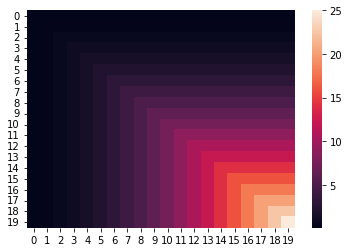

In [4]:
sigma_c=1
r_c=1/57
v=8
r_a = 0.25

covA, covC = covarianzas(r_a, sigma_c, r_c, v)
sns.heatmap(covA)

In [5]:
d=8
n = 500
mu1 = np.zeros(20)+d/2
    
XA = np.random.multivariate_normal(np.zeros(20), 2*covA, size=1) + v*np.arange(1,21)
XC = np.random.multivariate_normal(2*mu1, 2*covC, size=1)
X = np.concatenate((XA, XC), axis=1)

ZA = np.random.multivariate_normal(np.zeros(20), 2*covA, size=n) + v*np.arange(1,21)
ZC = np.random.multivariate_normal(2*mu1, 2*covC, size=n)
Z=np.concatenate((ZA, ZC), axis=1)

In [8]:
print(XA.shape, XC.shape, X.shape)
print(ZA.shape, ZC.shape, Z.shape)

(1, 20) (1, 20) (1, 40)
(500, 20) (500, 20) (500, 40)


# Simulaciones con modelo AR (Construcción de la cadena de markov)

In [ ]:
rho = 0.9  # coeficiente
rho_bar = np.sqrt(1-rho**2)


for i in range(500):
  XC = np.append(XC, rho*(XC[-1:,]-2*mu1) + rho_bar*(ZC[i,:]-2*mu1)+2*mu1,axis=0)
  XA = np.append(XA, rho*(XA[-1:,]) + rho_bar*(ZA[i,:]),axis=0)                  # en la componente accros, no interviene la distancia
  X=np.concatenate((XA, XC), axis=1)

print(XA.shape, XC.shape, X.shape)

# Encontrar distancias parciales convenientes

In [11]:
a = 0.1
seuil = 0.98
rho = 0.9

rho_bar = np.sqrt(1-rho**2)
d=8
n=500

niveles = NiveauxSplitting2(a,  seuil, rho, rho_bar, n, d)
niveles

[5.292689133010765,
 3.7198538833319277,
 2.5817873316368414,
 1.5479975855443433,
 0.4066838898699339,
 0.14304406327777766,
 0.1]

# Encontrar la probabilidad de conflicto usando las distancias parciales

In [12]:
def probaAR(a, rho, rho_bar, n, d, niveaux):       
    
    mu1=np.zeros(20)+d/2.

    # Simulación de las cadenas para encontrar la probabilidad condicional
    ##  con un N cada vez más grande entre menor es la distancia
   
    XA = np.random.multivariate_normal(np.zeros(20), 2*covA,size=1)
    XC = np.random.multivariate_normal(2*mu1, 2*covC,size=1)
    X=np.concatenate((XA, XC), axis=1)

    ZA = np.random.multivariate_normal(np.zeros(20), 2*covA,size=n)
    ZC = np.random.multivariate_normal(2*mu1, 2*covC,size=n)
    Z=np.concatenate((ZA, ZC), axis=1)
    ## Distancia Parcial 0:
    for i in range(n):
        XC = np.append(XC, rho*(XC[-1:,]-2*mu1) + rho_bar*(ZC[i,:]-2*mu1)+2*mu1,axis=0)
        XA = np.append(XA, rho*(XA[-1:,]) + rho_bar*(ZA[i,:]),axis=0)
        X=np.concatenate((XA, XC), axis=1)
    
    # Distancia mínima al cuadrado por simulación
    l=np.sqrt( np.amin(X[:,:20]*X[:,:20]+X[:,20:]*X[:,20:],axis=1))
    #Probabilidad de que distancia mínima se acerque más allá del primer corte en d
    P = [ np.mean(l<=niveaux[0]) ]
    

    ## Distancia Parcial l en adelante
    k = len(niveaux)
    for l in range(1,k):
        ## Recuperamos la distancia más pequeña
        m = np.sqrt(np.amin(X[:,:20]*X[:,:20]+X[:,20:]*X[:,20:],axis=1))
        d_parcial_ant = niveaux[(l-1)]
        count_true=sum(m <= d_parcial_ant)
        if(count_true>0):
          startingPoint = (X[m <= d_parcial_ant][0])
        else:
          X=np.array(sorted(list(X),key=lambda x:min(x[:20]**2+x[20:]**2)))
          startingPoint = X[0]
       
        X=np.array([startingPoint]) 
        XA=X[:,:20]
        XC=X[:,20:]    
      
        ZA = np.random.multivariate_normal(np.zeros(20), 2*covA,size=n)
        ZC = np.random.multivariate_normal(2*mu1, 2*covC,size=n)
        Z=np.concatenate((ZA, ZC), axis=1)
        for i in range(n):
         
          newXA=rho*(XA[-1:,]) + rho_bar*(ZA[i,:])
          newXC= rho*(XC[-1:,]-2*mu1) + rho_bar*(ZC[i,:]-2*mu1)+2*mu1
          alpha=np.sqrt(np.amin(newXA*newXA+newXC*newXC))
          XC = np.append(XC, newXC*(alpha <=d_parcial_ant )+X[-1:,20:]*(alpha >d_parcial_ant ),axis=0)
          XA = np.append(XA, newXA*(alpha <=d_parcial_ant )+X[-1:,:20]*(alpha >d_parcial_ant ),axis=0)
          X=np.concatenate((XA, XC), axis=1)
        
        P.append( np.mean(np.sqrt(np.amin(X[:,:20]*X[:,:20]+X[:,20:]*X[:,20:],axis=1))<=niveaux[l]) )
    #Obtenemos la probabilidad final
    Proba_emp_split =np.prod(P)

    return(Proba_emp_split)

In [13]:
## Parametros del problema
a = 0.1
rho = 0.9

rho_bar = np.sqrt(1-rho**2)
d=8
n=1000
probaAR(a,  rho, rho_bar, n,d, niveles)

3.491172050241965e-10

In [14]:
# Calculamos el erro de nuestra estimación
a = 0.1
seuil = 0.99
rho = 0.9

rho_bar = np.sqrt(1-rho**2)
d=6
n=500

niveles = NiveauxSplitting2(a,  seuil, rho, rho_bar, 500, d)


a = 0.1
rho = 0.9
rho_bar = np.sqrt(1-rho**2)
n=1500
l=[]
for i in range(10):
  l.append(probaAR(a,  rho, rho_bar, n, d, niveles))

h=[np.mean(l),np.var(l),2*((np.var(l)/n)**0.5)]
print(h)

[1.0212067981836018e-06, 8.374445623274848e-13, 4.7256592127871e-08]
